# Exercise: Lane Detection using Hough Transform in OpenCV

---

Prof. Dr.-Ing. Antje Muntzinger, Hochschule für Technik Stuttgart

antje.muntzinger@hft-stuttgart.de

---

The following notebook is based on Udacity's *Self-Driving Car Nanodegree*.

In this exercise, we implement and experiment with several methods to find lanes lines in street images. Let's take a look at our first example image:

This image is:  <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


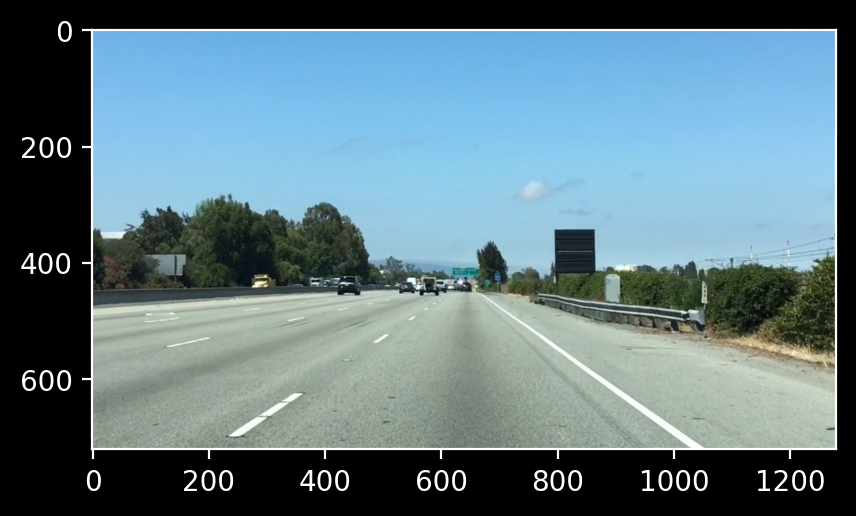

In [2]:
#doing all the relevant imports
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

# Read in the image and print some stats
image = mpimg.imread('../images/street.jpg')
print('This image is: ', type(image), 
         'with dimensions:', image.shape)

plt.imshow(image)


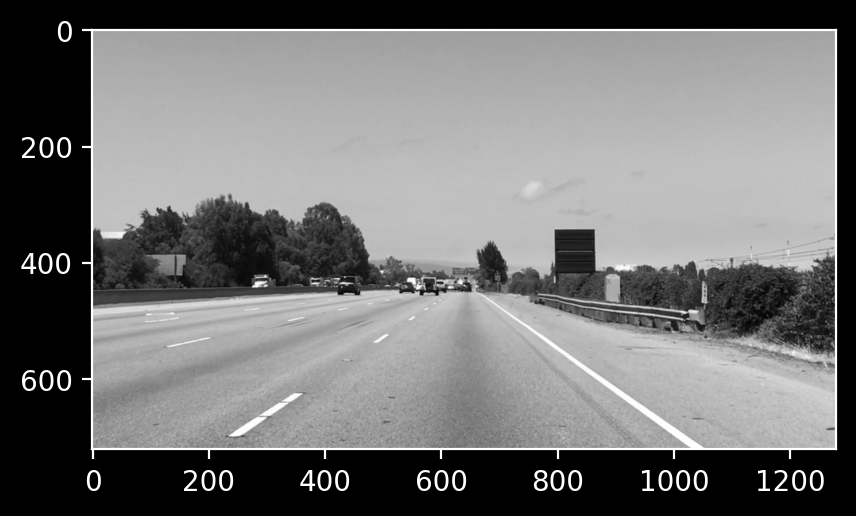

In [3]:
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) #grayscale conversion
plt.imshow(gray, cmap='gray')

## 1. Color Selection

We want to detect the white lane lines. So the simplest idea is to use a color threshold, keeping only the white pixels. So I define a color threshold in the variables red_threshold, green_threshold, and blue_threshold and populate rgb_threshold with these values. This vector contains the minimum values for red, green, and blue (R,G,B) that I will allow in my selection.

(-0.5, 1279.5, 719.5, -0.5)

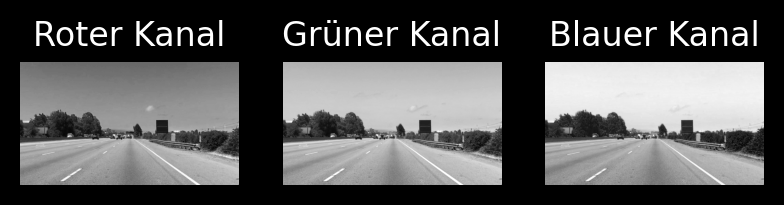

In [4]:
# YOUR CODE GOES HERE

img_R, img_G, img_B = cv2.split(image)
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
ax1.imshow(img_R, cmap='gray')
ax1.set_title("Roter Kanal")
ax1.axis("off")
ax2.imshow(img_G, cmap='gray')
ax2.set_title("Grüner Kanal")
ax2.axis("off")
ax3.imshow(img_B, cmap='gray')
ax3.set_title("Blauer Kanal")
ax3.axis("off")

The white lane is present in all color channels since white is [255, 255, 255].

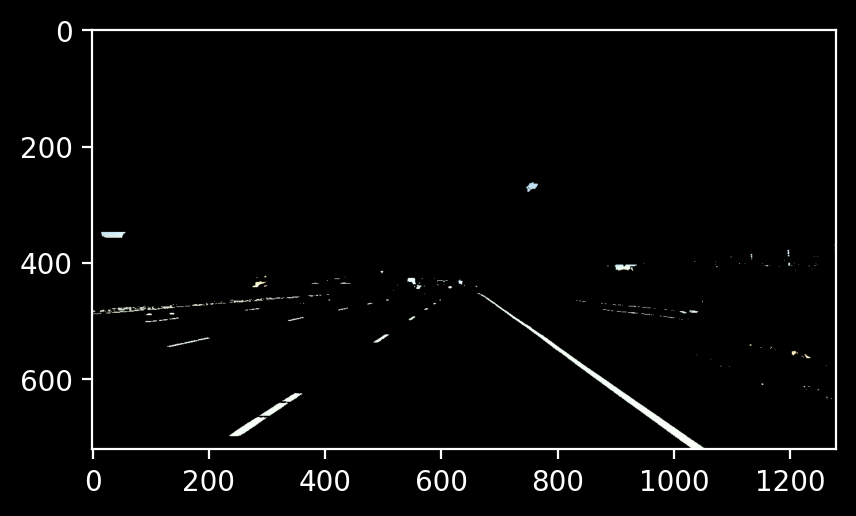

In [8]:
# Grab the x and y size and make a copy of the image
ysize = image.shape[0]
xsize = image.shape[1]
color_select = np.copy(image)

# Define color selection criteria
red_threshold = 0
green_threshold = 220
blue_threshold = 0

rgb_threshold = [red_threshold, green_threshold, blue_threshold]

# Do a boolean or with the "|" character to identify
# pixels below the thresholds
thresholds = (image[:,:,0] < rgb_threshold[0]) \
            | (image[:,:,1] < rgb_threshold[1]) \
            | (image[:,:,2] < rgb_threshold[2])
color_select[thresholds] = [0,0,0]

# Display the image                 
plt.imshow(color_select)


The result, color_select, is an image in which pixels that were above the threshold have been retained, and pixels below the threshold have been blacked out.
In the code snippet above, red_threshold, green_threshold and blue_threshold are all set to 0, which implies all pixels will be included in the selection. 

**TODO:** Modify the values of red_threshold, green_threshold and blue_threshold above until you retain as much of the lane lines as possible while dropping everything else.

**HINT:** You can split the image into separate color channels and visualize them to get clues about which color channel is most important here.

## 2. Coding up a Region of Interest Mask

Awesome! Now you've seen that with a simple color selection we have managed to eliminate almost everything in the image except the lane lines. 
At this point, however, it would still be tricky to extract the exact lines automatically, because we still have some other objects detected around the periphery that aren't lane lines.

In this case, I'll assume that the front facing camera that took the image is mounted in a fixed position on the car, such that the lane lines will always appear in the same general region of the image. Next, I'll take advantage of this by adding a criterion to only consider pixels for color selection in the region where we expect to find the lane lines.

Check out the code below. The variables left_bottom, right_bottom, and apex represent the vertices of a triangular region that I would like to retain for my color selection, while masking everything else out. Here I'm using a triangular mask to illustrate the simplest case, but later you'll use a quadrilateral, and in principle, you could use any polygon.

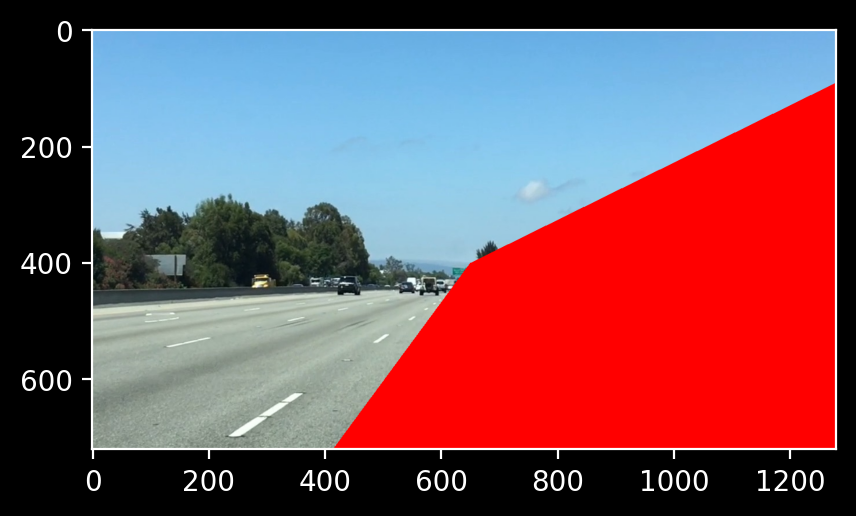

In [13]:
# Make a copy of the image
region_select = np.copy(image)

# Define a triangle region of interest 
# Keep in mind the origin (x=0, y=0) is in the upper left in image processing
# Note: if you run this code, you'll find these are not sensible values!!
# But you'll get a chance to play with them soon in a quiz 
left_bottom = [0, ysize]
right_bottom = [1, xsize]
apex = [650, 400]

# Fit lines (y=Ax+B) to identify the  3 sided region of interest
# np.polyfit() returns the coefficients [A, B] of the fit
fit_left = np.polyfit((left_bottom[0], apex[0]), (left_bottom[1], apex[1]), 1)
fit_right = np.polyfit((right_bottom[0], apex[0]), (right_bottom[1], apex[1]), 1)
fit_bottom = np.polyfit((left_bottom[0], right_bottom[0]), (left_bottom[1], right_bottom[1]), 1)

# Find the region inside the lines
XX, YY = np.meshgrid(np.arange(0, xsize), np.arange(0, ysize))
# The region inside the lines is defined by the lines' equations. Conditions are:
# y> Ax + B for left and right lines
# y< Ax + B for bottom line
# A and B are found using np.polyfit() above (fit_left, fit_right, fit_bottom)
region_thresholds = (YY > (XX*fit_left[0] + fit_left[1])) & \
                    (YY > (XX*fit_right[0] + fit_right[1])) & \
                    (YY < (XX*fit_bottom[0] + fit_bottom[1]))

# Color pixels red which are inside the region of interest
region_select[region_thresholds] = [255, 0, 0]

# Display the image
plt.imshow(region_select)

## 3. Combining Color and Region Selections

Now you've seen how to mask out a region of interest in an image. Next, let's combine the mask and color selection to pull only the lane lines out of the image. 

Check out the code below. Here we’re doing both the color and region selection steps, requiring that a pixel meet both the mask and color selection requirements to be retained. 

**TODO:** Vary your color selection and the shape of your region mask (vertices of a triangle left_bottom, right_bottom, and apex), such that you pick out the lane lines and nothing else. We just want our ego-lane, not the neighboring lanes left or right!

In [ ]:
color_select = np.copy(image)
line_image = np.copy(image)

# Define color selection criteria
red_threshold = 0
green_threshold = 0
blue_threshold = 0

rgb_threshold = [red_threshold, green_threshold, blue_threshold]

# Define the vertices of a triangular mask.
# Keep in mind the origin (x=0, y=0) is in the upper left
left_bottom = [0, 539]
right_bottom = [900, 300]
apex = [400, 0]

# Perform a linear fit (y=Ax+B) to each of the three sides of the triangle
# np.polyfit returns the coefficients [A, B] of the fit
fit_left = np.polyfit((left_bottom[0], apex[0]), (left_bottom[1], apex[1]), 1)
fit_right = np.polyfit((right_bottom[0], apex[0]), (right_bottom[1], apex[1]), 1)
fit_bottom = np.polyfit((left_bottom[0], right_bottom[0]), (left_bottom[1], right_bottom[1]), 1)

# Mask pixels below the threshold
color_thresholds = (image[:,:,0] < rgb_threshold[0]) | \
                    (image[:,:,1] < rgb_threshold[1]) | \
                    (image[:,:,2] < rgb_threshold[2])

# Find the region inside the lines
XX, YY = np.meshgrid(np.arange(0, xsize), np.arange(0, ysize))
region_thresholds = (YY > (XX*fit_left[0] + fit_left[1])) & \
                    (YY > (XX*fit_right[0] + fit_right[1])) & \
                    (YY < (XX*fit_bottom[0] + fit_bottom[1]))
                    
# Mask color and region selection
color_select[color_thresholds | ~region_thresholds] = [0, 0, 0]
# Color pixels red where both color and region selections met
line_image[~color_thresholds & region_thresholds] = [255, 0, 0]

# Display the image and show region and color selections
plt.imshow(image)
x = [left_bottom[0], right_bottom[0], apex[0], left_bottom[0]]
y = [left_bottom[1], right_bottom[1], apex[1], left_bottom[1]]
plt.plot(x, y, 'b--', lw=4)
plt.imshow(color_select)
plt.show()
plt.imshow(line_image)
plt.show()

## 4. Canny Edge Detection

So you found the lane lines... simple right? Now you’re ready to upload the algorithm to the car and drive autonomously right?? Well, not quite yet ;)
As it happens, lane lines are not always the same color, and even lines of the same color under different lighting conditions (day, night, etc) may fail to be detected by our simple color selection.
What we need is to take our algorithm to the next level to detect lines of any color using sophisticated computer vision methods. 

**TODO:** Apply Gaussian blur and Canny edge detection to the `image2` below. This image is more challenging due to the yellow line. Store your resulting edge image in a variable called `masked_edges`. Plot your result. Which parameters work best?

In [ ]:
# Read in the image and print some stats
image2 = mpimg.imread('images/exit-ramp.jpg')
gray2 = cv2.cvtColor(image2, cv2.COLOR_RGB2GRAY) #grayscale conversion
print('This image is: ', type(image2), 
         'with dimensions:', image2.shape)

plt.imshow(image2)

In [ ]:
# TODO: YOUR CODE GOES HERE



We have detected nice lane lines - but also a lot of other edges! So we need something better, which leads us to the Hough transform.

## 5. Implementing a Hough Transform on Edge Detected Image

You already know how the Hough Transform works, but to accomplish the task of finding lane lines, we need to specify some parameters to say what kind of lines we want to detect (i.e., long lines, short lines, bendy lines, dashed lines, etc.). 
To do this, we'll be using an OpenCV function called HoughLinesP that takes several parameters. Let's code it up and find the lane lines in the image we detected edges in with the Canny function (for a look at coding up a Hough Transform from scratch, check this out: https://alyssaq.github.io/2014/understanding-hough-transform/)

Let's look at the input parameters for the OpenCV function HoughLinesP that we will use to find lines in the image. You will call it like this:
```
lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                                             min_line_length, max_line_gap)
```
In this case, we are operating on the image masked_edges (the output from Canny) and the output from HoughLinesP will be lines, which will simply be an array containing the endpoints (x1, y1, x2, y2) of all line segments detected by the transform operation. The other parameters define just what kind of line segments we're looking for. 

- First off, rho and theta are the distance and angular resolution of our grid in Hough space. Remember that, in Hough space, we have a grid laid out along the (Θ, ρ) axis. You need to specify rho in units of pixels and theta in units of radians. 
So, what are reasonable values? Well, rho takes a minimum value of 1, and a reasonable starting place for theta is 1 degree (pi/180 in radians). Scale these values up to be more flexible in your definition of what constitutes a line.
- The threshold parameter specifies the minimum number of votes (intersections in a given grid cell) a candidate line needs to have to make it into the output. 
- The empty np.array([]) is just a placeholder, no need to change it. 
- min_line_length is the minimum length of a line (in pixels) that you will accept in the output, and max_line_gap is the maximum distance (again, in pixels) between segments that you will allow to be connected into a single line. 
 
You can then iterate through your output lines and draw them onto the image to see what you got!
So, here's what its going to look like:



In [ ]:
# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 1
theta = np.pi/180
threshold = 1
min_line_length = 10
max_line_gap = 1
line_image = np.copy(image2)*0 #creating a blank to draw lines on

# Run Hough on edge detected image
lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)

# Iterate over the output "lines" and draw lines on the blank
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)

# Create a "color" binary image to combine with line image
color_edges = np.dstack((masked_edges, masked_edges, masked_edges)) 

# Draw the lines on the edge image
combo = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0) 
plt.imshow(combo)

As you can see, I've detected lots of line segments! Your job, in the next exercise, is to figure out which parameters do the best job of optimizing the detection of the lane lines. Then, you'll want to apply a region of interest mask to filter out detected line segments in other areas of the image. Earlier in this lesson you used a triangular region mask, but this time you'll get a chance to use a quadrilateral region mask using the cv2.fillPoly() function (keep in mind though, you could use this same method to mask an arbitrarily complex polygon region). When you're finished you'll be ready to apply the skills you've learned to do the assignment at the end of this lesson. 

## 6. Putting it all together

**TODO:** Now it's your turn to play with the Hough Transform on an edge-detected image. Your job is to modify the parameters for the Hough Transform and impose a region of interest mask to get output that does a better job finding just the lane lines than the image above. In the code, I've given you a framework for defining a quadrilateral region of interest mask. 


In [ ]:
# Read in and grayscale the image
image2 = mpimg.imread('images/exit-ramp.jpg')
gray2 = cv2.cvtColor(image2,cv2.COLOR_RGB2GRAY)

# Define a kernel size and apply Gaussian smoothing
kernel_size = 5
blur_gray = cv2.GaussianBlur(gray2,(kernel_size, kernel_size),0)

# Define our parameters for Canny and apply
low_threshold = 50
high_threshold = 150
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)

# Next we'll create a masked edges image using cv2.fillPoly()
mask = np.zeros_like(edges)   
ignore_mask_color = 255   

# This time we are defining a four sided polygon to mask (we can still define a triangular region with 4 vertices, but we are more flexible)
imshape = image2.shape
vertices = np.array([[(0,imshape[0]),(0, 0), (imshape[1], 0), (imshape[1],imshape[0])]], dtype=np.int32)
cv2.fillPoly(mask, vertices, ignore_mask_color)
masked_edges = cv2.bitwise_and(edges, mask)

# Plot the rectangular region mask
plt.imshow(masked_edges, cmap='Greys_r')
plt.plot(vertices[0][:, 0], vertices[0][:, 1], 'b--', lw=4)
plt.show()

# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 1     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 5 #minimum number of pixels making up a line
max_line_gap = 1    # maximum gap in pixels between connectable line segments
line_image = np.copy(image2)*0 # creating a blank to draw lines on

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)

# Iterate over the output "lines" and draw lines on a blank image
for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)

# Create a "color" binary image to combine with line image
color_edges = np.dstack((edges, edges, edges)) 

# Draw the lines on the edge image
lines_edges = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0) 
plt.imshow(lines_edges)


Great, we now know the basics of how autonomous cars can detect lane lines using Hough transform!

### Tuning Parameters
Parameter tuning is one of the biggest challenges in computer vision - what works well for one image may not work at all with different lighting and/or backgrounds.
Computer Vision Engineers gain an intuition over time for ranges of parameters and different techniques that might work best for a set of situations. When getting started, this can be a big hill to climb. Oftentimes, building a tool to help speed up your iteration between different techniques and thresholds can help you in parameter tuning.
While it's not required for the project, you might consider reading this blog post from a Self-Driving Car student on their approach to a parameter tuning tool, and consider building one of your own in the future! https://medium.com/@maunesh/finding-the-right-parameters-for-your-computer-vision-algorithm-d55643b6f954